### Comparison between the LIM code by Bernal and the LIM implementation in Zeus21 by Libanore 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib as mpl
#plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

# import zeus libraries
import zeus21
from zeus21 import LIM as zeusLIM
from zeus21 import cosmology

# import LIM libraries
import sys
sys.path.insert(0,'/home/sarah/LIM/')
from lim import lim as L
from astropy import units as u
from astropy import constants as cu

#### 1) Setup cosmological, astrophysical and line parameters

In [2]:
# cosmo params
CosmoParams_input = zeus21.Cosmo_Parameters_Input(HMF_CHOICE='ST')
ClassyCosmo = zeus21.runclass(CosmoParams_input)
CosmoParams = zeus21.Cosmo_Parameters(CosmoParams_input, ClassyCosmo) 

# halo mass function
HMF_interpolator = zeus21.HMF_interpolator(CosmoParams,ClassyCosmo)

In [3]:
# astro params
AstroParams = zeus21.Astro_Parameters(CosmoParams)

In [4]:
# line params
LineParams_input = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 3, # for now we consider radius larger than NL level 
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.5)
LineParams = zeus21.Line_Parameters(LineParams_input) 

LineParams_input_lin = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 500, # for now we consider radius larger than NL level 
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.5)
LineParams_lin = zeus21.Line_Parameters(LineParams_input_lin) 

LineParams_input_nl = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 0.5, # for now we consider radius larger than NL level 
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.5)
LineParams_nl = zeus21.Line_Parameters(LineParams_input_nl) 

# CII line
nu=LineParams.CII_nu_rest*u.Hz
alpha_CII_0 = LineParams.CII_alpha_SFR_0
alpha_CII_z = LineParams.CII_alpha_SFR_z
beta_CII_0 = LineParams.CII_beta_SFR_0
beta_CII_z = LineParams.CII_beta_SFR_z

In [5]:
# observed redshift 
zObs=10.

In [6]:
# Zeus21 run 
CoeffStructure = zeus21.get_LIM_coefficients(CosmoParams,  AstroParams, HMF_interpolator, LineParams, zmin=zObs)
CorrFClass = zeus21.Correlations_LIM(LineParams, CosmoParams, ClassyCosmo)
PSLIM = zeus21.Power_Spectra_LIM(CosmoParams, AstroParams, LineParams, CorrFClass, 'here we will put 21cm coeffs', CoeffStructure, RSD_MODE = 0)

/home/sarah/anaconda3/envs/zeus21/lib/python3.9/site-packages/zeus21/LIM.py:287: RuntimeWarning: divide by zero encountered in log10
  log10_L = alpha_SFR * np.log10(SFR) + beta_SFR


In [7]:
# Zeus21 run on large scales
CoeffStructure_lin = zeus21.get_LIM_coefficients(CosmoParams,  AstroParams, HMF_interpolator, LineParams_lin, zmin=zObs)
CorrFClass_lin = zeus21.Correlations_LIM(LineParams_lin, CosmoParams, ClassyCosmo)
PSLIM_lin = zeus21.Power_Spectra_LIM(CosmoParams, AstroParams, LineParams_lin, CorrFClass_lin, 'here we will put 21cm coeffs', CoeffStructure_lin, RSD_MODE = 0)

The resolution allows for fully linear calculation


In [8]:
# Zeus21 run on small scales
CoeffStructure_nl = zeus21.get_LIM_coefficients(CosmoParams,  AstroParams, HMF_interpolator, LineParams_nl, zmin=zObs)
CorrFClass_nl = zeus21.Correlations_LIM(LineParams_nl, CosmoParams, ClassyCosmo)
PSLIM_nl = zeus21.Power_Spectra_LIM(CosmoParams, AstroParams, LineParams_nl, CorrFClass_nl, 'here we will put 21cm coeffs', CoeffStructure_nl, RSD_MODE = 0)

Your resolution introduces too large non linear corrections on small scales! 
It should have been changed in the input file, check why this did not happened


In [9]:
# dictionary for the LIM code 
input_params = dict(cosmo_code ='class',
                     cosmo_input_class=dict(f_NL=0,
                       H0=CosmoParams.h_fid*100.,omega_b=CosmoParams.omegab, omega_cdm=CosmoParams.omegac, 
                A_s=CosmoParams.As,n_s=CosmoParams.ns,
                #N_ncdm=3, m_ncdm='0.02,0.02,0.02', N_ur = 0.00641, USE DEFAULT FROM CLASS
                output='mPk,mTk'))

astro_params = dict(model_type='ML', # use mass-luminosity relation
                 model_name='CII_zeus21', 
                 model_par={'alpha_CII_0':alpha_CII_0,
                 'alpha_CII_z':alpha_CII_z, 'beta_CII_0':beta_CII_0,'beta_CII_z':beta_CII_z,
                 'Cosmo_Parameters':CosmoParams,
                 'HMF_interpolator':HMF_interpolator,
                 'Astro_Parameters':AstroParams,
                 },
                 hmf_model='ST_zeus',
                 bias_model='ST99',
                 bias_par={}, #Otherwise, write a dict with the corresponding values
                 nu=nu,
                 nuObs=nu/(1+zObs),
                 Mmin=HMF_interpolator.Mhtab[0]*u.Msun,
                 Mmax=HMF_interpolator.Mhtab[-1]*u.Msun,
                 nM=1500,
                 Lmin=10*u.Lsun,
                 Lmax=1e15*u.Lsun,
                 nL=5000,
                 v_of_M=None, # to apply line width
                 line_incli=False,) # account for randomly inclined line profiles

pk_params = dict(kmin = 1e-4*u.Mpc**-1, # in the line power spectrum
                 kmax = 1e3*u.Mpc**-1, # in the line power spectrum
                 nk = 1000,
                 k_kind = 'log',
                 sigma_scatter=0., # scatter in the mass-luminosity relation
                 fduty=1.,
                 do_onehalo=False, # testing linear for now
                 do_Jysr=False,
                 do_RSD=False, # testing without RSD for now
                 sigma_NL=7*u.Mpc, # scale for non linearities in FoG
                 nmu=1000,
                 FoG_damp='Lorentzian',
                 smooth=False,
                 do_conv_Wkmin = False,
                 nonlinear=False,) # using the non linear matter power spectrum in PKint

input_params.update(astro_params)
input_params.update(pk_params)

In [10]:
# LIM run
ll = L(input_params)

#### Matter power spectrum 

Note that in order to perform the integrations in $k$ in a reasonable way, in LIM we need to expand the $k$ range beyond the observable.

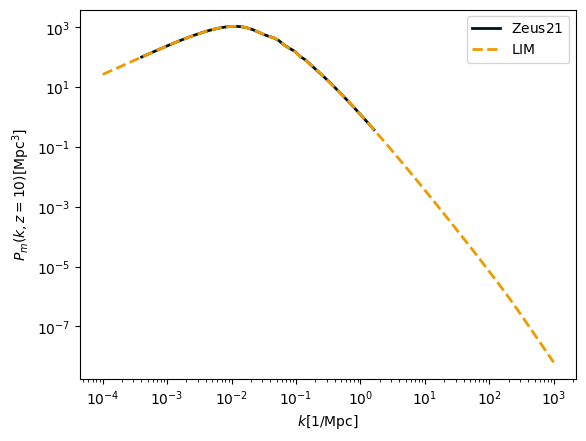

In [13]:
# Zeus21
kZ = CorrFClass._klistCF
PmZ_funct = lambda kk: ClassyCosmo.pk(kk, zObs)
PmZ = np.vectorize(PmZ_funct)(kZ) 

# LIM 
kL = ll.k 
PmL = ll.PKint(kL,np.array([zObs]),len(kL),1,0)*u.Mpc**3

plt.loglog(kZ,PmZ, '-', label = r'$\rm Zeus21$')
plt.loglog(kL,PmL, color=colors[5], linestyle='--', label = r'$\rm LIM$')
plt.xlabel(r'$k [1/{\rm Mpc}]$')
plt.ylabel(r'$P_m(k,z=%g) [{\rm Mpc}^3]$'%zObs)
plt.legend()

#### $\sigma_M$ and $d\sigma_M/dM_h$

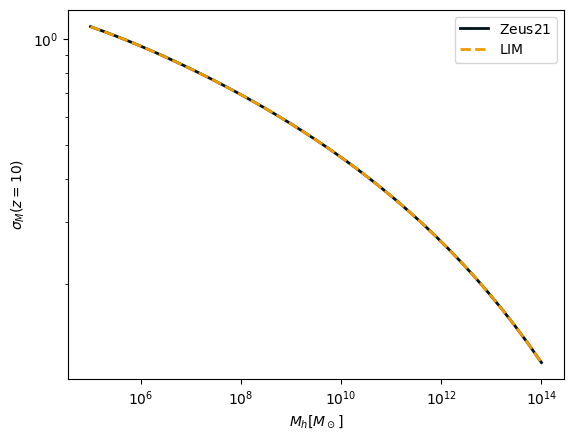

In [14]:
# Zeus21
MZ = HMF_interpolator.Mhtab
sigmaMZ = HMF_interpolator.sigmaMhtab[:,11]

# LIM 
ML = ll.M
sigmaML = ll.sigmaM

plt.loglog(MZ,sigmaMZ, '-', label = r'$\rm Zeus21$')
plt.loglog(ML,sigmaML, color=colors[5], linestyle='--', label = r'$\rm LIM$')
plt.xlabel(r'$M_h [M_\odot]$')
plt.ylabel(r'$\sigma_M(z=%g)$'%zObs)
plt.legend()

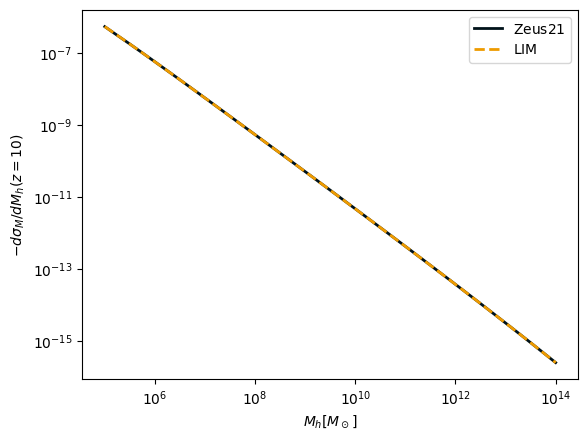

In [15]:
# Zeus21
MZ = HMF_interpolator.Mhtab
dsigmaMZ = HMF_interpolator.dsigmadMMhtab[:,11]

# LIM 
ML = ll.M
dsigmaML = ll.dsigmaM_dM

plt.loglog(MZ,-dsigmaMZ, '-', label = r'$\rm Zeus21$')
plt.loglog(ML,-dsigmaML, color=colors[5], linestyle='--', label = r'$\rm LIM$')
plt.xlabel(r'$M_h [M_\odot]$')
plt.ylabel(r'$-d\sigma_M/dM_h(z=%g)$'%zObs)
plt.legend()

#### Halo mass function

We implemented in LIM the same halo mass function as in Zeus21, i.e. the ST halo mass function:

$\frac{dn}{dM_h}=-A_{\rm ST} \sqrt{\frac{2}{\pi}} \tilde{\nu} (1. + \tilde{\nu}^{-2p_{\rm ST}}) \times$

$\qquad\qquad\times\exp(\frac{-\tilde{\nu}^2}{2}) \frac{\rho_{M0}}{M_h \sigma_M}\frac{d\sigma_M}{dM_h}$

where

$\tilde{\nu} =\sqrt{a_{\rm ST}}\frac{\delta_C}{\sigma_M}$

(1e-30, 1.0)

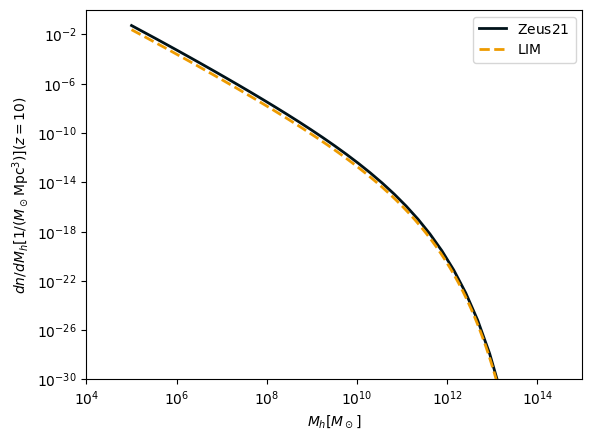

In [16]:
# Zeus21
MZ = HMF_interpolator.Mhtab
hmfZ =  np.exp(HMF_interpolator.logHMFint((np.log(MZ), zObs)))

# LIM 
ML = ll.M
hmfL = ll.dndM

plt.loglog(MZ,hmfZ, '-', label = r'$\rm Zeus21$')
plt.loglog(ML,hmfL, color=colors[5], linestyle='--', label = r'$\rm LIM$')
plt.xlabel(r'$M_h [M_\odot]$')
plt.ylabel(r'$dn/dM_h [1/(M_\odot{\rm Mpc}^3)](z=%g)$'%zObs)
plt.legend()
plt.xlim(1e4,1e15)
plt.ylim(1e-30,1e0)

#### Average luminosity 


We model the mass to line luminosity for CII as 

$\log_{10}L(M_h,z) = \alpha_0\log_{10}\rm SFR + \beta_0$

and then we estimate the average luminosity density as

$\bar{\rho_L} = \int d\log M_h\, \frac{dn}{dM_h}M_h\,L(M_h) $

/home/sarah/anaconda3/envs/zeus21/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(1e-30, 10000000000.0)

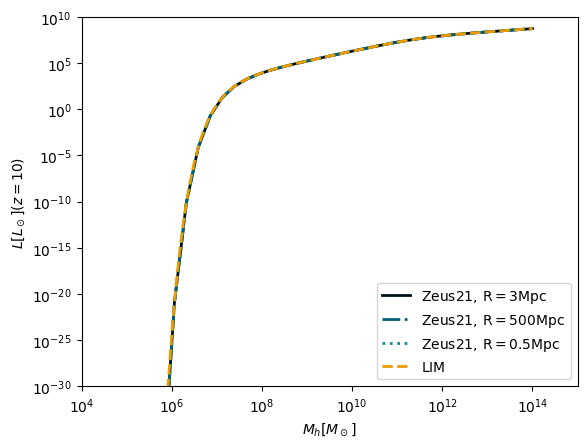

In [17]:
# Zeus21
MZ = HMF_interpolator.Mhtab
LZ =  zeusLIM.LineLuminosity(LineParams,AstroParams,CosmoParams,HMF_interpolator,MZ,zObs)
LZ_lin =  zeusLIM.LineLuminosity(LineParams_lin,AstroParams,CosmoParams,HMF_interpolator,MZ,zObs)
LZ_nl =  zeusLIM.LineLuminosity(LineParams_nl,AstroParams,CosmoParams,HMF_interpolator,MZ,zObs)

# LIM 
ML = ll.M
LL = ll.LofM

plt.loglog(MZ,LZ, '-', label = r'$\rm Zeus21, \, R= %g Mpc$'%LineParams._R)
plt.loglog(MZ,LZ_lin, '-.', label = r'$\rm Zeus21, \, R= %g Mpc$'%LineParams_lin._R)
plt.loglog(MZ,LZ_nl, ':', label = r'$\rm Zeus21, \, R= %g Mpc$'%LineParams_nl._R)
plt.loglog(ML,LL, color=colors[5], linestyle='--', label = r'$\rm LIM$')
plt.xlabel(r'$M_h [M_\odot]$')
plt.ylabel(r'$L [L_\odot](z=%g)$'%zObs)
plt.legend()
plt.xlim(1e4,1e15)
plt.ylim(1e-30, 1e10)

We estimate the value of $\bar{\rho_L}$ at $z=10$.

In [18]:
print('Average log10 rhoL in Zeus (R=' +str(LineParams._R) + ' Mpc) = ' + str(np.log10(CoeffStructure.rhoL_avg[0])) + ' Lsun / Mpc3')
print('Average log10 rhoL in Zeus (R=' +str(LineParams_lin._R) + ' Mpc) = ' + str(np.log10(CoeffStructure_lin.rhoL_avg[0])) + ' Lsun / Mpc3')
print('Average log10 rhoL in Zeus (R=' +str(LineParams_nl._R) + ' Mpc) = ' + str(np.log10(CoeffStructure_nl.rhoL_avg[0])) + ' Lsun / Mpc3')
print('Average log10 rhoL in LIM = ' + str(np.log10(ll.Lmean.value)) + ' Lsun / Mpc3')

Average log10 rhoL in Zeus (R=3 Mpc) = 5.165336656785094 Lsun / Mpc3
Average log10 rhoL in Zeus (R=500 Mpc) = 5.165336656785094 Lsun / Mpc3
Average log10 rhoL in Zeus (R=0.5 Mpc) = 5.165336656785094 Lsun / Mpc3
Average log10 rhoL in LIM = 4.827629555908004 Lsun / Mpc3


#### Observed intensity / brightness temperature

We define the observed mean intensity (in units of brightness temperature) as 

$\bar{I}_\nu = \frac{c^3(1+z)^2}{8\pi k_B H(z)\nu_{\rm rest}^3}\bar{\rho_L}$

In [19]:
print('Bar Inu in Zeus (R=' +str(LineParams._R) + ' Mpc)= ' + str(CoeffStructure.Inu_avg[0]) + ' uK')
print('Bar Inu in Zeus (R=' +str(LineParams_lin._R) + ' Mpc)= ' + str(CoeffStructure_lin.Inu_avg[0]) + ' uK')
print('Bar Inu in Zeus (R=' +str(LineParams_nl._R) + ' Mpc)= ' + str(CoeffStructure_nl.Inu_avg[0]) + ' uK')
print('Bar Inu in LIM = ' + str(ll.Tmean))

Bar Inu in Zeus (R=3 Mpc)= 0.05865247413854306 uK
Bar Inu in Zeus (R=500 Mpc)= 0.05865247413854306 uK
Bar Inu in Zeus (R=0.5 Mpc)= 0.05865247413854306 uK
Bar Inu in LIM = 0.026951270058843978 uK


#### LIM power spectrum 

In the linear case, the LIM code models the power spectrum (without noise or observational windows) as

$P_{\rm LIM}(k)= {\rm RSD}( P_{2h}+P_{1h})$

$P_{2h} = P_m(k)I_\nu^2b_\nu^2 $ 

where the bias is modeled as 

$b_\nu = \frac{\int dM_h b_h(M_h) L(M_h) dn/dM_h}{\int dM_h L(M_h) dn/dM_h} $

and for the moment we do not consider RSD.

Instead, in the Zeus21 version the linear power specrum is modeled as 

$P^{\rm lin}_{\rm LIM}(k) = c_1^2c_2^2\gamma_{R_0}^2 P_m^{\rm lin}(k)$

where 

$c_1 = \frac{c^3(1+z)^2}{8\pi k_B H(z)\nu_{\rm rest}^3},\quad c_2 = \bar{\rho}_L$

and $R_0$ is the scale below which we cannot resolve LIM sources. Note that $\gamma_{R_0}$ contains the growth factor.

In the previous expression we used the approximation $\exp(\gamma_{R_0}\gamma_{R_0}\xi^{R_0R_0}-1) \simeq 1+ \gamma_{R_0}\gamma_{R_0}\xi^{R_0R_0}$ and hence ${\rm FT}[\exp(\gamma_{R_0}\gamma_{R_0}\xi^{R_0R_0})]= \gamma_{R_0}^2{\rm FT}[\xi^{R_0R_0}]$.

To account for non linear contributions to this approximation, we account for the correction $NL = \exp(\gamma_{R_0}\gamma_{R_0}\xi^{R_0R_0}) - (1+\gamma_{R_0}\gamma_{R_0}\xi^{R_0R_0})$ and we add them to the adimensional power spectrum through

$\Delta_{\rm LIM}^2 = \frac{k^3}{2\pi^2}P^{\rm lin}_{\rm LIM}(k) + \frac{k^3}{2\pi^2}NL$

only if the scale $R_0$ is smaller than the $R_{NL}^{\rm max}=100 \,{\rm Mpc}$. If the scale is smaller than  $R_{NL}^{\rm min}=0.5 \,{\rm Mpc}$, we simply set it to  $R_{NL}^{\rm min}$ to avoid numerical problems.

(0.001, 1.0)

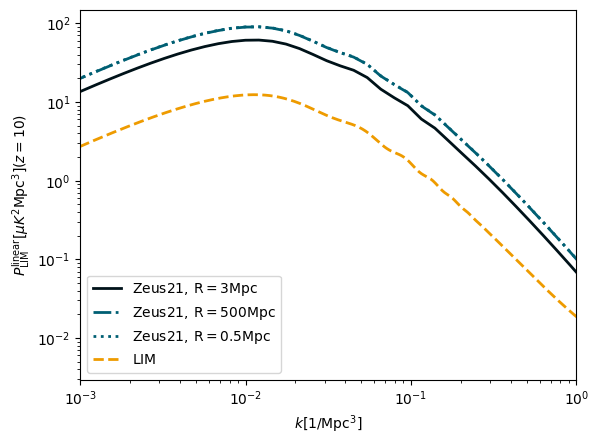

In [44]:
# Zeus21
kZ = PSLIM.klist_PS
PklinZ = PSLIM._Pk_LIM_lin[0]
PklinZ_lin = PSLIM_lin._Pk_LIM_lin[0]
PklinZ_nl = PSLIM_nl._Pk_LIM_lin[0]
# LIM 
kL = ll.k
PklinL = ll.Pk[0]

plt.loglog(kZ,PklinZ, '-', label = r'$\rm Zeus21,\,R=%g Mpc$'%LineParams._R)
plt.loglog(kZ,PklinZ_lin, '-.', label = r'$\rm Zeus21,\,R=%g Mpc$'%LineParams_lin._R)
plt.loglog(kZ,PklinZ_nl, color=colors[1], linestyle=':', label = r'$\rm Zeus21,\,R=%g Mpc$'%LineParams_nl._R)
plt.loglog(kL,PklinL, color=colors[5], linestyle='--', label = r'$\rm LIM$')
plt.xlabel(r'$k [1/{\rm Mpc}^3]$')
plt.ylabel(r'$P_{\rm LIM}^{\rm linear} [\mu K^2  {\rm Mpc^3}](z=%g)$'%zObs)
plt.legend()
plt.xlim(1e-3,1e0)

When non linearities are considered, the LIM code models the power spectrum (without noise or observational windows) as

$P_{\rm LIM}(k)= {\rm RSD} (P_{2h}+P_{1h})$

$P_{2h} = P_m(k)[\frac{c^3(1+z)^2}{8\pi H(z)\nu_{\rm rest}^3}\int dM_h\, L\frac{dn}{dM_h} f_{\rm NFW}]^2 $ 

$P_{1h} =  \frac{c^3(1+z)^2}{8\pi H(z)\nu_{\rm rest}^3}\int dM_h\, L^2\frac{dn}{dM_h} f_{\rm NFW}^2$

where $f_{\rm NFW}$ is the Fourier transform of the Navarro Frenk White profile and for the moment we do not consider RSD.

In [42]:
pk_params_1h = dict(kmin = 1e-4*u.Mpc**-1, # in the line power spectrum
                 kmax = 1e3*u.Mpc**-1, # in the line power spectrum
                 nk = 1000,
                 k_kind = 'log',
                 sigma_scatter=0., # scatter in the mass-luminosity relation
                 fduty=1.,
                 do_onehalo=True, # testing linear for now
                 do_Jysr=False,
                 do_RSD=False, # testing without RSD for now
                 sigma_NL=7*u.Mpc, # scale for non linearities in FoG
                 nmu=1000,
                 FoG_damp='Lorentzian',
                 smooth=False,
                 do_conv_Wkmin = False,
                 nonlinear=False,) # using the non linear matter power spectrum in PKint

input_params.update(pk_params_1h)

# LIM run
ll_1h = L(input_params)

(1e-07, 0.01)

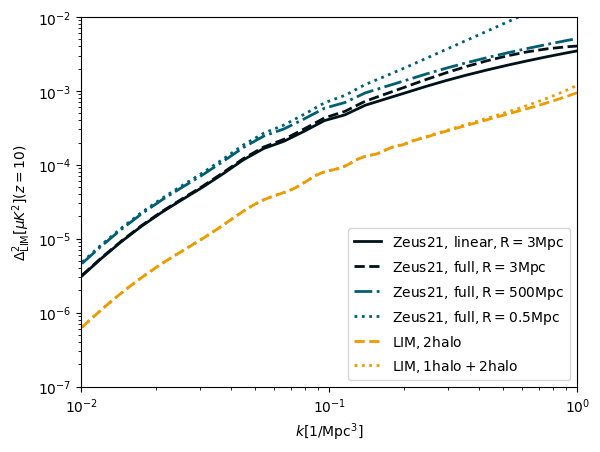

In [48]:
# Zeus21
kZ = PSLIM.klist_PS
Delta_PklinZ =  PSLIM.Deltasq_LIM_lin[0]
Delta_PkZ =  PSLIM.Deltasq_LIM[0]

Delta_PkZ_lin =  PSLIM_lin.Deltasq_LIM[0]

Delta_PkZ_nl =  PSLIM_nl.Deltasq_LIM[0]

# LIM 
kL = ll.k
Delta_PklinL = ll.Pk[0] * kL**3 / 2 / np.pi**2
Delta_PkL = ll_1h.Pk[0] * kL**3 / 2 / np.pi**2

plt.loglog(kZ,Delta_PklinZ, '-', label = r'$\rm Zeus21,\, linear, R=%g Mpc$'%LineParams._R)
plt.loglog(kZ,Delta_PkZ, color=colors[0], linestyle='--',label = r'$\rm Zeus21,\, full, R=%g Mpc$'%LineParams._R)
plt.loglog(kZ,Delta_PkZ_lin, linestyle='-.',label = r'$\rm Zeus21,\, full, R=%g Mpc$'%LineParams_lin._R)
plt.loglog(kZ,Delta_PkZ_nl,color=colors[1], linestyle=':',label = r'$\rm Zeus21,\, full, R=%g Mpc$'%LineParams_nl._R)
plt.loglog(kL,Delta_PklinL, color=colors[5], linestyle='--', label = r'$\rm LIM, 2halo$')
plt.loglog(kL,Delta_PkL, color=colors[5], linestyle=':', label = r'$\rm LIM, 1halo+2halo$')
plt.xlabel(r'$k [1/{\rm Mpc}^3]$')
plt.ylabel(r'$\Delta^2_{\rm LIM} [\mu K^2](z=%g)$'%zObs)
plt.legend()
plt.xlim(1e-2,1e0)
plt.ylim(1e-7, 1e-2)

Finally, from the Zeus code we can compute the cross correlation between LIM and the density field. This is defined as 

$\Delta^2_{\rm LIM,\delta}(k)= \frac{k^3}{2\pi^2}(c_1c_2\gamma_{R_0}D(z)P_m^{\rm lin}(k)+{\rm FT}[\xi^{NL}])$

where $D(z)$ is the growth factor (we consider $P_{\delta\delta}(k)=D^2(z)P_m^{\rm lin}(k)$) and $\xi^{NL}$ is the correlation function with non linear correction as in the previous step. 

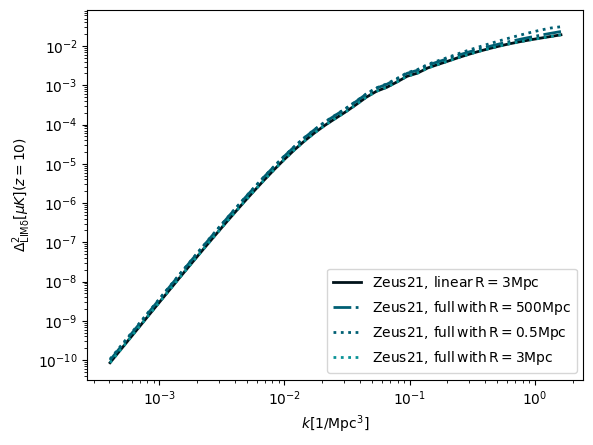

In [50]:
# Zeus21
kZ = PSLIM.klist_PS
Delta_cross_PklinZ =  PSLIM.Deltasq_dLIM_lin[0]
Delta_cross_PkZ =  PSLIM.Deltasq_dLIM[0]
Delta_cross_PkZ_lin =  PSLIM_lin.Deltasq_dLIM[0]
Delta_cross_PkZ_nl =  PSLIM_nl.Deltasq_dLIM[0]

plt.loglog(kZ,Delta_cross_PklinZ, '-', label = r'$\rm Zeus21,\, linear\, R=%g Mpc$'%LineParams._R)
plt.loglog(kZ,Delta_cross_PkZ_lin, linestyle='-.', label = r'$\rm Zeus21,\, full\, with\, R=%g Mpc$'%LineParams_lin._R)
plt.loglog(kZ,Delta_cross_PkZ_nl, color=colors[1],linestyle=':', label = r'$\rm Zeus21,\, full\, with\, R=%g Mpc$'%LineParams_nl._R)
plt.loglog(kZ,Delta_cross_PkZ, color=colors[2], linestyle=':', label = r'$\rm Zeus21,\, full\, with\, R=%g Mpc$'%LineParams._R)
plt.xlabel(r'$k [1/{\rm Mpc}^3]$')
plt.ylabel(r'$\Delta^2_{\rm LIM\delta} [\mu K](z=%g)$'%zObs)
plt.legend()

The correlation can be used to generate maps that are correlated with the density field. The following plots are produced using PowerBox to extract the fluctuations given the power spectrum. In particular the density field $\delta_m$ is produced using $P_{\delta\delta}(k)$, while the LIM map is produced following the steps:

1) generate $P_{\rm LIM \delta}(k)$
2) calculate $\mathcal{R} = $P_{\rm LIM \delta}(k)$ / P_{\delta \delta}(k)$
3) scale the density field $\delta_m(k)$ by $\mathcal{R}$
4) transform the field in real space and sum it the average intensity $\bar{I}_\nu$, to provide a ground level. 

This is the linear map.


If you want to add power excess due to non linear correction:
1) estimate the excess of power due to corrections through $(\Delta_{\rm LIM}^2-\Delta_{\rm LIM,linear}^2)k^3/2\pi^2$
2) divide the excess of power by $\bar{I_\nu}$ to normalize
3) generate overdesnities in real space using a lognormal distribition with power spectrum the corrections just computed
4) multiply the output by $\bar{I}_\nu$ and sum it to the linear map

In the plot we also show the 21cm map at the same redshift, for reference.

In [21]:
CorrFClass_21 = zeus21.Correlations(CosmoParams, ClassyCosmo)
CoeffStructure_21 = zeus21.get_T21_coefficients(CosmoParams, ClassyCosmo, AstroParams, HMF_interpolator, zmin=zObs)
PS21 = zeus21.Power_Spectra(CosmoParams, AstroParams, ClassyCosmo, CorrFClass_21, CoeffStructure_21, RSD_MODE = 0)

Cell size = 0.5 Mpc


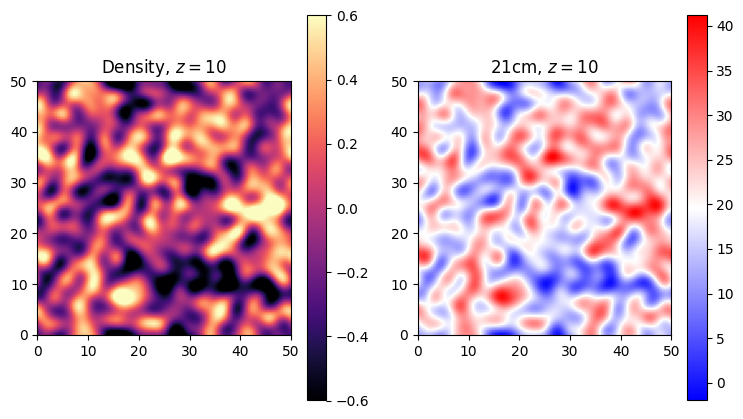

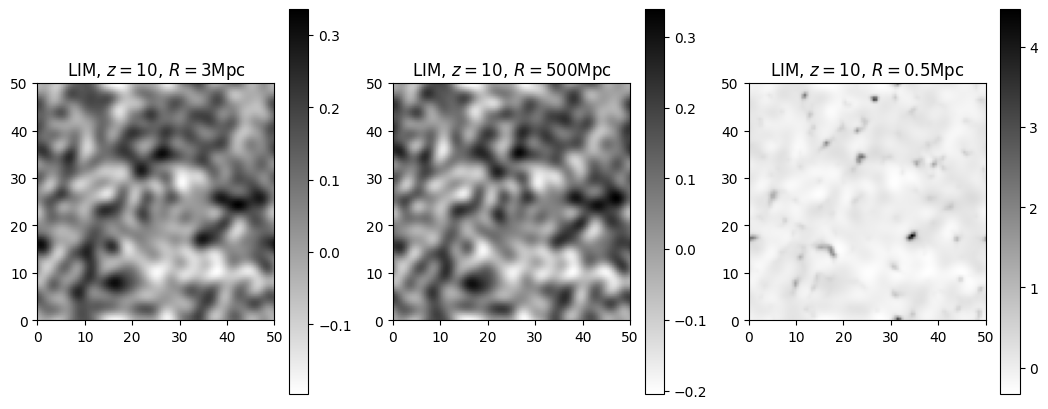

In [54]:
zval = 10.
Lbox = 50
Nbox = 100

Mapz = zeus21.CoevalMaps_LIM(CoeffStructure, PSLIM, PS21, zval, KIND=1, Lbox = Lbox, Nbox = Nbox)

Mapz_lin = zeus21.CoevalMaps_LIM(CoeffStructure_lin, PSLIM_lin, PS21, zval, KIND=1, Lbox = Lbox, Nbox = Nbox)

Mapz_nl = zeus21.CoevalMaps_LIM(CoeffStructure_nl, PSLIM_nl, PS21, zval, KIND=1, Lbox = Lbox, Nbox = Nbox)

Mapz_21 = zeus21.CoevalMaps(CoeffStructure_21, PS21, zval, KIND=1, Lbox = Lbox, Nbox = Nbox)
print('Cell size = ' + str(Lbox/Nbox) + ' Mpc')

_islice = 0

plt.figure(figsize=(9,5))
plt.subplot(121)
plt.imshow(Mapz.deltamap[_islice],extent=(0,Mapz.Lbox,0,Mapz.Lbox),cmap='magma',vmin=-0.6,vmax=0.6)
plt.title(r'${\rm Density},\, z = %g\,$'%zval )
plt.colorbar()


plt.subplot(122)
plt.imshow(Mapz_21.T21map[_islice],extent=(0,Mapz_21.Lbox,0,Mapz_21.Lbox),cmap='bwr') 
plt.title(r'${\rm 21cm,\,}z = %g$'%zval )
plt.colorbar()


plt.figure(figsize=(13,5))
plt.subplot(131)
plt.imshow(Mapz.LIMmap[_islice],extent=(0,Mapz.Lbox,0,Mapz.Lbox),cmap='binary') 
plt.title(r'${\rm LIM,\,}z = %g,\,$'%zval + r'$R = %g{\rm Mpc}$'%LineParams._R)
plt.colorbar()

plt.subplot(132)
plt.imshow(Mapz_lin.LIMmap[_islice],extent=(0,Mapz_lin.Lbox,0,Mapz_lin.Lbox),cmap='binary') 
plt.title(r'${\rm LIM,\,}z = %g,\,$'%zval + r'$R = %g{\rm Mpc}$'%LineParams_lin._R)
plt.colorbar()

plt.subplot(133)
plt.imshow(Mapz_nl.LIMmap[_islice],extent=(0,Mapz_nl.Lbox,0,Mapz_nl.Lbox),cmap='binary') 
plt.title(r'${\rm LIM,\,}z = %g,\,$'%zval + r'$R = %g{\rm Mpc}$'%LineParams_nl._R)
plt.colorbar()


And for reference, these are the 21cm and LIM power spectra.

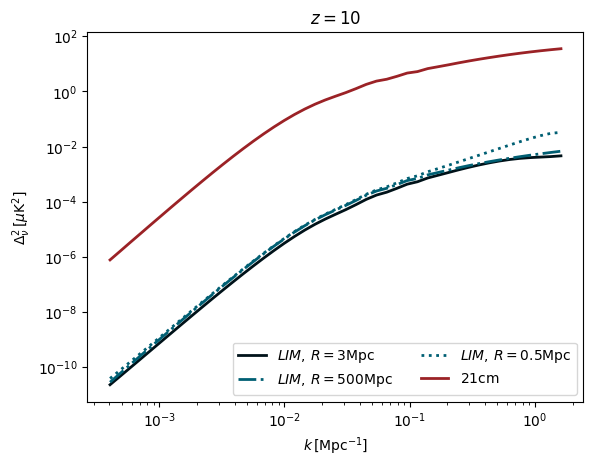

In [52]:
#choose a z to plot
klist = PSLIM.klist_PS
_iz = min(range(len(CoeffStructure.zintegral)), key=lambda i: np.abs(CoeffStructure.zintegral[i]-zObs))

plt.title(r'$z = %g$'%zObs)
plt.loglog(klist,PSLIM.Deltasq_LIM[_iz], '-', label= r'$LIM,\,R= %g{\rm Mpc}$'%LineParams._R)
plt.loglog(klist,PSLIM_lin.Deltasq_LIM[_iz], '-.', label= r'$LIM,\,R= %g{\rm Mpc}$'%LineParams_lin._R)
plt.loglog(klist,PSLIM_nl.Deltasq_LIM[_iz], color=colors[1],linestyle=':', label= r'$LIM,\,R= %g{\rm Mpc}$'%LineParams_nl._R)
plt.loglog(klist,PS21.Deltasq_T21[_iz], '-', color=colors[-1], label=r'$\rm 21cm$')

plt.xlabel(r'$k\,\rm [Mpc^{-1}]$');
plt.ylabel(r'$\Delta^2_{\nu}\,[\mu{\rm K}^2]$');
plt.legend(loc=4, ncol=2)